# Dynamics

Throughout the repo, we work with surrogate dynamics models—particularly with the `sindy_rl.dynamics.EnsembleSINDyDynamicsModel` class. The intent of this notebook is to show how we can interact with this class.

## Setup
To initialize the dynamics model, we need to pass a config dictionary. Here's an example below. There's a lot of components, and this may look very scary to start, but it's conveneient to keep everything config-driven. This helps us make quick changes to various parts if we ever need to. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from sindy_rl.dynamics import EnsembleSINDyDynamicsModel

In [2]:
NUM_MODELS = 20

dyna_config = {
    'callbacks': 'project_cartpole',
    'dt': 1,
    'discrete': True,

    # Optimizer config
    'optimizer': {
      'base_optimizer': {
        'name': 'STLSQ',
        'kwargs': {
          'alpha': 5.0e-5,
          'threshold': 7.0e-3,
            },
      },
      # Ensemble Optimization config
      'ensemble': {
        'bagging': True,
        'library_ensemble': True,
        'n_models': NUM_MODELS,
      },
    },
    # Dictionary/Libary Config
    'feature_library': {
      'name': 'affine', # use affine functions
      'kwargs': {
        'poly_deg': 3,
        'n_state': 5 ,
        'n_control': 1,
        'poly_int': True,
        'tensor': True,
      }
    }
}

dyn_model = EnsembleSINDyDynamicsModel(dyna_config)

## Collecting Data
To actually use the model, we need to collect data before fitting it. The easiest way to collect data is by rolling out experience in an environment. Here we load the cartpole swingup environment and rollout 8 trajecotries of size 1000.

In [3]:
from sindy_rl.env import rollout_env
from sindy_rl.registry import DMCEnvWrapper
from sindy_rl.policy import RandomPolicy

env_config = {'domain_name': "cartpole",
                'task_name': "swingup",
                'frame_skip': 1,
                'from_pixels': False}
cart_env = DMCEnvWrapper(env_config)


random_policy = RandomPolicy(cart_env.action_space)
traj_obs, traj_acts, traj_rews = rollout_env(cart_env, random_policy, n_steps = 4000, n_steps_reset=100)
#  This retruns n_+steps// n_steps_reset trajectories
#  Each has length n_steps_reset, with each sampel the obs shape

2024-06-30 17:48:53,016	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


Now we can fit the model to the data. Under the hood, `dyn_model` is mostly just a wrapper for a PySINDy ensemble dynamics model. We can access the model, it's optimizer, coeficients, etc. by calling `dyn_model.model`. We've incorporated a few methods to make it easier to work with the ensemble. E.g., we can set the model's coefficients to be the median coefficient.

In [4]:
# len(traj_obs)
# for obs in traj_obs:
#     print(obs.shape)


train_obs = traj_obs[:-1]
test_obs = traj_obs[-1]

train_acts = traj_acts[:-1]
test_acts = traj_acts[-1]
dyn_model.fit(train_obs, train_acts)


dyn_model.print()

(x0)[k+1] = 0.588 x0[k] + 0.003 x3[k] + -0.179 x0[k] x1[k] + 0.233 x0[k] x1[k]^2 + 0.354 x0[k] x2[k]^2 + 0.007 x1[k]^2 x3[k] + -0.005 x2[k]^2 x3[k] + 0.007 x2[k]^2 x4[k]
(x1)[k+1] = 0.059 x1[k] + 0.128 x0[k] x2[k] + -1.141 x1[k]^2 + -0.089 x2[k]^2 + 0.007 x2[k] x3[k] + 0.089 x0[k] x1[k] x2[k] + -0.200 x1[k]^3 + 0.287 x1[k] x2[k]^2 + 0.025 x1[k] x2[k] x3[k]
(x2)[k+1] = -37.956 x2[k] + -14.376 x3[k] + -77.865 x1[k] x2[k] + -29.057 x1[k] x3[k] + 0.059 x2[k]^2 + 1.284 x2[k] x4[k] + 0.309 x0[k]^2 x2[k] + -0.037 x0[k] x1[k] x2[k] + 0.130 x0[k] x2[k] x4[k] + -38.928 x1[k]^2 x2[k] + -14.690 x1[k]^2 x3[k] + 1.287 x1[k] x2[k] x4[k] + 0.971 x2[k]^3 + 0.317 x2[k]^2 x3[k] + -0.035 x2[k] x3[k]^2 + 0.083 x2[k] x3[k] x4[k]
(x3)[k+1] = 0.003 x2[k] + 0.714 x3[k] + -0.004 x1[k] x2[k] + 0.095 x1[k] x3[k] + -0.009 x2[k]^2 + -0.010 x2[k] x3[k] + 0.381 x1[k]^2 x3[k] + -0.010 x1[k] x2[k]^2 + -0.010 x1[k] x2[k] x3[k] + 0.333 x2[k]^2 x3[k] + -0.131 u0[k] + -0.273 x1[k] u0[k] + -0.243 x1[k]^2 u0[k] + 0.111 x2[k]

In [5]:
#  Validate models from ensemble
print(dyn_model.validate_ensemble(test_obs[0], test_acts, test_obs, verbose = True))

 15%|█▌        | 3/20 [00:00<00:03,  5.14it/s]/home/vgavra/.local/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/vgavra/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 35%|███▌      | 7/20 [00:01<00:01,  6.58it/s]/home/vgavra/.local/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/vgavra/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 40%|████      | 8/20 [00:01<00:01,  6.64it/s]/home/vgavra/.local/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow en

[array([[-5.04550524e-04, -9.99999702e-01,  7.58754206e-04,
         8.55145510e-04, -5.08356420e-03],
       [-4.98184735e-04, -9.99986846e-01,  7.36726341e-04,
         6.26408259e-02,  8.47831766e-02],
       [ 1.18383632e-04, -9.99964993e-01,  1.45321251e-04,
        -1.18556981e-02, -2.32643688e-02],
       [ 7.52922283e-08, -9.99925518e-01,  2.51730321e-04,
        -1.99964386e-02, -3.50698354e-02],
       [-1.98485969e-04, -9.99856035e-01,  4.30202997e-04,
        -7.26642687e-02, -1.11538035e-01],
       [-9.15208940e-04, -9.99733413e-01,  1.08224008e-03,
        -3.79005882e-03, -1.14839094e-02],
       [-9.54590161e-04, -9.99518610e-01,  1.09586733e-03,
        -1.47309469e-02, -2.72049267e-02],
       [-1.10028089e-03, -9.99140676e-01,  1.20354715e-03,
         7.14641565e-02,  9.81218326e-02],
       [-4.11729154e-04, -9.98478128e-01,  5.87967192e-04,
         1.05138641e-01,  1.47248630e-01],
       [ 5.85164709e-04, -9.97313172e-01, -2.20040320e-04,
         3.41011931e-0

## Compare Ensembling Techniques
Below, we can evaluate our dynamics model on our test set by rolling out the dynamics. 

In [6]:

dyn_model.set_mean_coef_()
mean_obs = [test_obs[0]]

for u in test_acts:
    x = mean_obs[-1]
    x_new = dyn_model.predict(x, u)
    mean_obs.append(x_new)

mean_obs = np.array(mean_obs)



# again for the mean observation
dyn_model.set_mean_coef_(valid=True)
mean_valid_obs = [test_obs[0]]

for u in test_acts:
    x = mean_valid_obs[-1]
    x_new = dyn_model.predict(x, u)
    mean_valid_obs.append(x_new)

mean_valid_obs = np.array(mean_valid_obs)


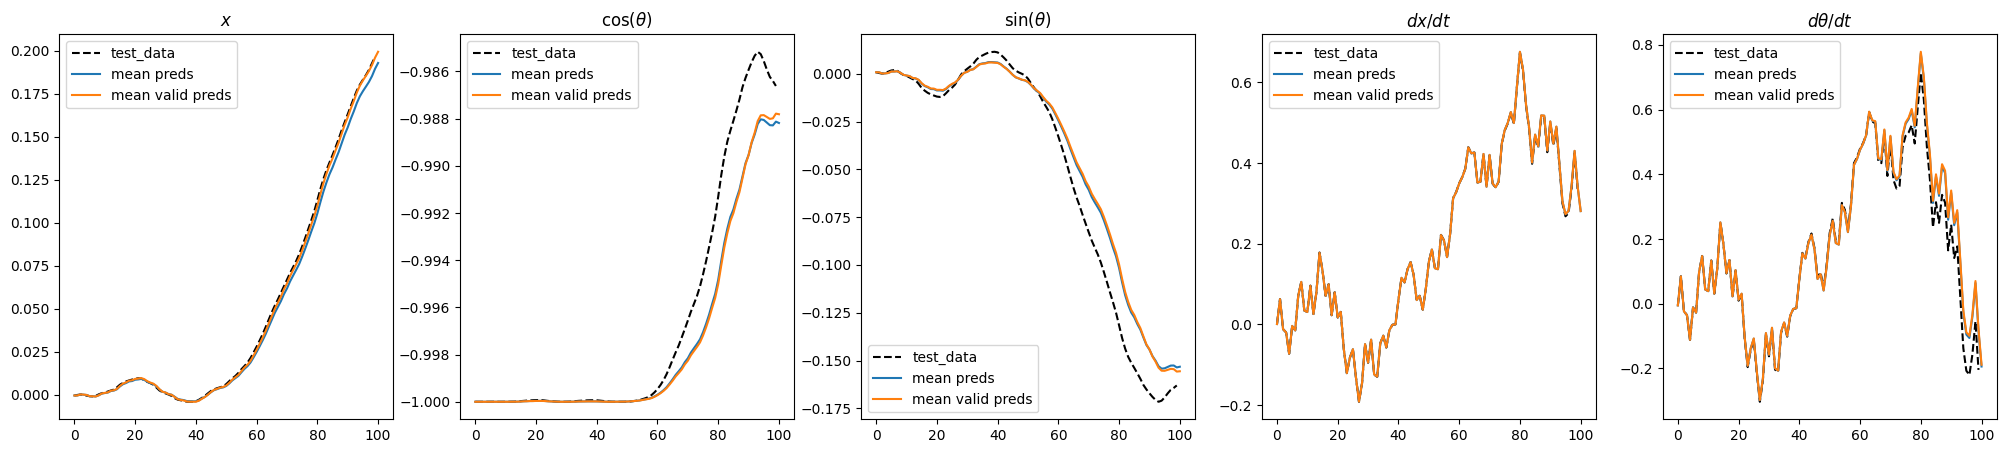

In [7]:
fig, axes  = plt.subplots(1,5, figsize=(25,5))

plt_labels = [r'$x$', r'$\cos(\theta)$', r'$\sin(\theta)$', r'$dx/dt$', r'$d \theta / dt$']

for i, ax in enumerate(axes.flatten()):

    ax.plot(test_obs[:,i], 'k--', label = 'test_data')
    ax.plot(mean_obs[:, i], label = 'mean preds')
    ax.plot(mean_valid_obs[:, i], label = 'mean valid preds')
    ax.set_title(plt_labels[i])
    ax.legend()

We can also do this for ALL the models!

In [40]:
all_preds = []

for idx in tqdm(range(NUM_MODELS)):
    dyn_model.set_idx_coef_(idx)
    obs_list = [test_obs[0]]

    for u in test_acts:
        x = obs_list[-1]
        try:
            x_new = dyn_model.predict(x, u)
            obs_list.append(x_new)
        except ValueError:
            print('!! Integration blew up !!')
            # backtrak just for plotting purposes.
            obs_list = obs_list[:-10]
            break

    obs_list = np.array(obs_list)
    all_preds.append(obs_list)


100%|██████████| 20/20 [00:03<00:00,  5.69it/s]


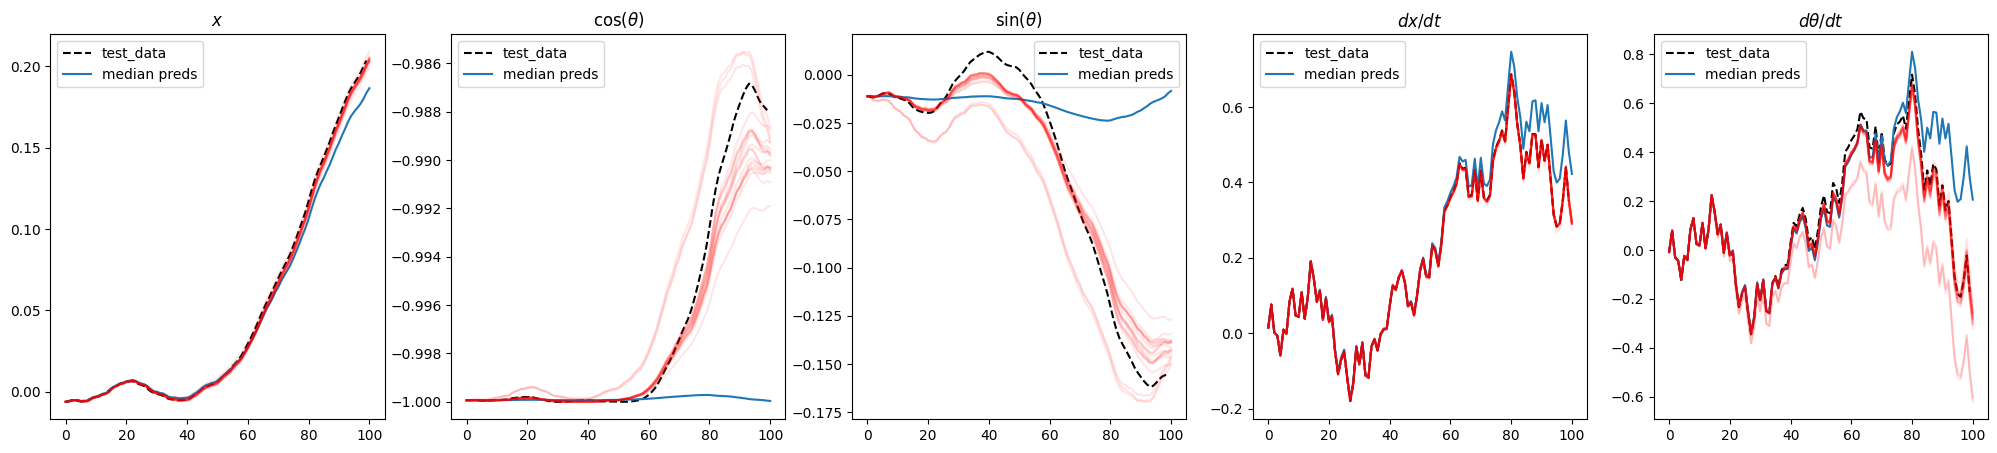

In [41]:
fig, axes  = plt.subplots(1,5, figsize=(25,5))

for i, ax in enumerate(axes.flatten()):

    ax.plot(test_obs[:,i], 'k--', label = 'test_data')
    ax.plot(median_obs[:, i], label = 'median preds')

    for pred_obs in all_preds:
        ax.plot(pred_obs[:, i], c='r', alpha = 0.1)
    ax.legend()
    ax.set_title(plt_labels[i])


## Note on Reward API
The reward API is nearly identical, except we don't wrap a pysindy model---though we _do_ use the pysindy package to provide a lot of the same functionality. Same when we fit sparse policies.